<a href="https://colab.research.google.com/github/MehakArora/ImageInpainting/blob/main/ImageInpainting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import


In [11]:
!pip3 install --upgrade opencv-contrib-python

     |████████████████████████████████| 66.7 MB 25 kB/s 
  Attempting uninstall: opencv-contrib-python
    Found existing installation: opencv-contrib-python 4.1.2.30
    Uninstalling opencv-contrib-python-4.1.2.30:
      Successfully uninstalled opencv-contrib-python-4.1.2.30


In [1]:
import tensorflow as tf
print(tf.__version__)
from tensorflow import keras


2.8.0


In [15]:
import os
import cv2
print(cv2.__version__)
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
from skimage.metrics import structural_similarity as SSIM

from mpl_toolkits.axes_grid1 import ImageGrid

4.5.5


## Intel Dataset

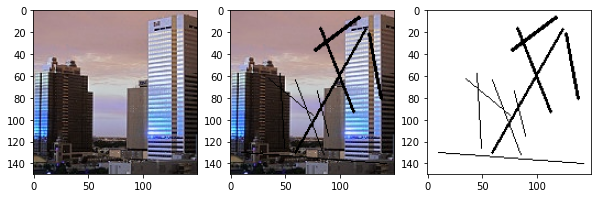

In [46]:
img = cv2.imread('5.jpg')


def createMask( img):
    ## Prepare masking matrix
    
    mask = np.full(img.shape, 255, np.uint8)
    for _ in range(np.random.randint(1, 10)):
      # Get random x locations to start line
      x1, x2 = np.random.randint(1, img.shape[0]), np.random.randint(1, img.shape[1])
      # Get random y locations to start line
      y1, y2 = np.random.randint(1, img.shape[0]), np.random.randint(1, img.shape[1])
      # Get random thickness of the line drawn
      thickness = np.random.randint(1, 3)
      # Draw black line on the white mask
      cv2.line(mask,(x1,y1),(x2,y2),(1,1,1),thickness)

    # Perforn bitwise and operation to mak the image
    masked_image = cv2.bitwise_and(img, mask)

    return masked_image, mask

masked_image, mask = createMask(img)

fig, a = plt.subplots(1, 3, figsize = (10,10))
a[0].imshow(img)
a[1].imshow(masked_image)
a[2].imshow(mask)


In [47]:
mask_inp = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
print(np.unique(mask_inp))
mask_inp[mask_inp != 1] = 0
print(np.unique(mask_inp))
mask_inp_inv = 1-mask_inp
print(np.unique(mask_inp_inv))


[  1 255]
[0 1]
[0 1]


Text(0.5, 0, 'PSNR : 33.10144888936696\nSSIM: 0.9837826926557844')

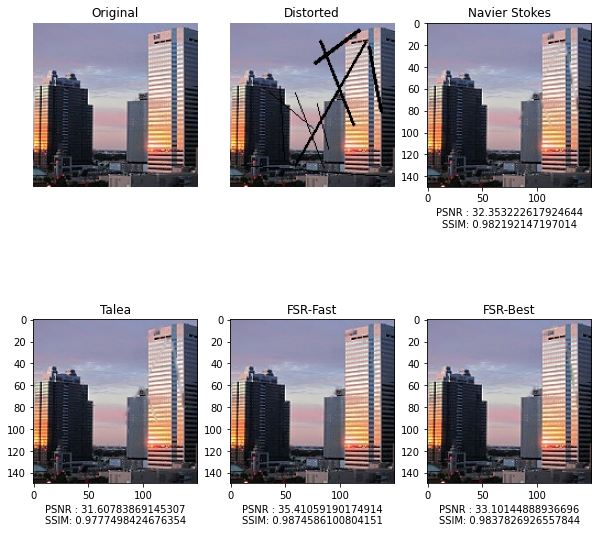

In [48]:
i = 0

outputNS = cv2.inpaint(masked_image, mask_inp, 4, cv2.INPAINT_NS)
outputTelea = cv2.inpaint(masked_image, mask_inp, 4, cv2.INPAINT_TELEA)

outputFsrFast = masked_image.copy()
outputFsrBest = masked_image.copy()
cv2.xphoto.inpaint(masked_image, mask_inp_inv, outputFsrFast, cv2.xphoto.INPAINT_FSR_FAST)
cv2.xphoto.inpaint(masked_image, mask_inp_inv, outputFsrBest, cv2.xphoto.INPAINT_FSR_BEST)

dstFsrFast = cv2.cvtColor(outputFsrFast, cv2.COLOR_BGR2RGB)
dstFsrBest = cv2.cvtColor(outputFsrBest, cv2.COLOR_BGR2RGB)
dstNS = cv2.cvtColor(outputNS, cv2.COLOR_BGR2RGB)
dstTelea = cv2.cvtColor(outputTelea, cv2.COLOR_BGR2RGB)
dst = cv2.cvtColor(masked_image, cv2.COLOR_BGR2RGB)
img1 = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

psnrNS = cv2.PSNR(img, outputNS, 255)
ssimNS = SSIM(img, outputNS, multichannel=True)

psnrTelea = cv2.PSNR(img, outputTelea, 255)
ssimTelea = SSIM(img, outputTelea, multichannel=True)

psnrFsrFast = cv2.PSNR(img, outputFsrFast, 255)
ssimFsrFast = SSIM(img, outputFsrFast, multichannel=True)

psnrFsrBest = cv2.PSNR(img, outputFsrBest, 255)
ssimFsrBest = SSIM(img, outputFsrBest, multichannel=True)

plt.figure(figsize=(10, 10))

plt.subplot(2, 3, 1)
plt.imshow(img1)
plt.axis('Off')
plt.title('Original')

plt.subplot(2, 3, 2)
plt.imshow(dst)
plt.axis('Off')
plt.title('Distorted')

plt.subplot(2, 3, 3)
plt.imshow(dstNS)
plt.title('Navier Stokes')
plt.xlabel('PSNR : ' + str(psnrNS) + '\nSSIM: ' + str(ssimNS))

plt.subplot(2, 3, 4)
plt.imshow(dstTelea)
plt.title('Talea')
plt.xlabel('PSNR : ' + str(psnrTelea) + '\nSSIM: ' + str(ssimTelea))

plt.subplot(2, 3, 5)
plt.imshow(dstFsrFast)
plt.title('FSR-Fast')
plt.xlabel('PSNR : ' + str(psnrFsrFast) + '\nSSIM: ' + str(ssimFsrFast))

plt.subplot(2, 3, 6)
plt.imshow(dstFsrBest)
plt.title('FSR-Best')
plt.xlabel('PSNR : ' + str(psnrFsrBest) + '\nSSIM: ' + str(ssimFsrBest))

## Cifar 10 Data

In [49]:
## Ref: https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly.
class createAugment(keras.utils.Sequence):
  'Generates data for Keras'
  def __init__(self, X, y, batch_size=32, dim=(32, 32), n_channels = 3, shuffle=True):
      'Initialization'
      self.batch_size = batch_size 
      self.X = X 
      self.y = y
      self.dim = dim
      self.n_channels = n_channels
      self.shuffle = shuffle
      
      self.on_epoch_end()

  def __len__(self):
      'Denotes the number of batches per epoch'
      return int(np.floor(len(self.X) / self.batch_size))

  def __getitem__(self, index):
      'Generate one batch of data'
      # Generate indexes of the batch
      indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

      # Generate data
      return self.__data_generation(indexes)

  def on_epoch_end(self):
      'Updates indexes after each epoch'
      self.indexes = np.arange(len(self.X))
      if self.shuffle:
          np.random.shuffle(self.indexes)

  def __data_generation(self, idxs):
    # X_batch is a matrix of masked images used as input
    X_batch = np.empty((self.batch_size, self.dim[0], self.dim[1], self.n_channels)) # Masked image
    # y_batch is a matrix of original images used for computing error from reconstructed image
    y_batch = np.empty((self.batch_size, self.dim[0], self.dim[1], self.n_channels)) # Original image
    m_batch = np.empty((self.batch_size, self.dim[0], self.dim[1], self.n_channels)) # Mask

    ## Iterate through random indexes
    for i, idx in enumerate(idxs):
      image_copy = self.X[idx].copy()
  
      ## Get mask associated to that image
      masked_image, mask = self.__createMask(image_copy)
      
      X_batch[i,] = masked_image
      y_batch[i] = self.y[idx]
      m_batch[i] = mask
      
    return X_batch, y_batch, m_batch

  def __createMask(self, img):
    ## Prepare masking matrix
    
    mask = np.full(img.shape, 255, np.uint8)
    for _ in range(np.random.randint(1, 10)):
      # Get random x locations to start line
      x1, x2 = np.random.randint(1, 32), np.random.randint(1, 32)
      # Get random y locations to start line
      y1, y2 = np.random.randint(1, 32), np.random.randint(1, 32)
      # Get random thickness of the line drawn
      thickness = np.random.randint(1, 3)
      # Draw black line on the white mask
      cv2.line(mask,(x1,y1),(x2,y2),(1,1,1),thickness)

    # Perforn bitwise and operation to mak the image
    masked_image = cv2.bitwise_and(img, mask)

    return masked_image, mask

In [50]:
## Cifar 10 Dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [51]:
## Prepare training and testing mask-image pair generator
traingen = createAugment(x_train, x_train)
testgen = createAugment(x_test, x_test, shuffle=False)

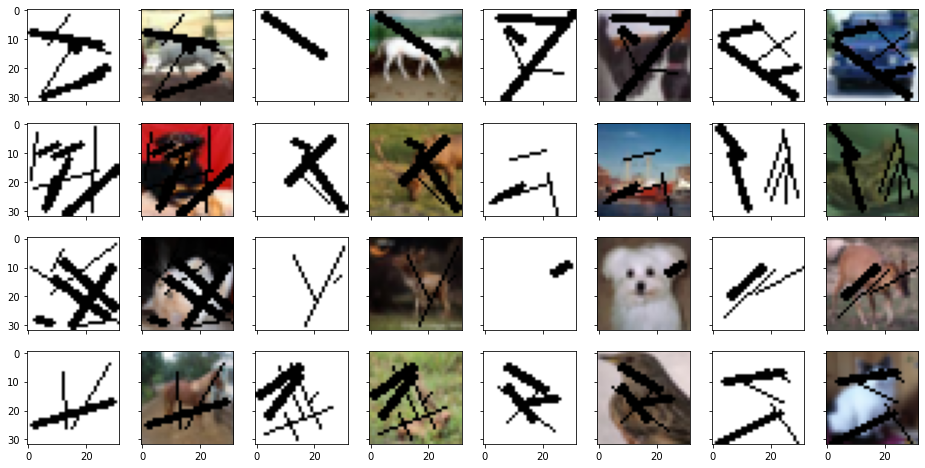

In [52]:
## Examples
sample_idx = 90 ## Change this to see different batches

sample_masked, sample_og, sample_masks = traingen[sample_idx]
sample_masked = sample_masked.astype('uint8')
sample_masks = sample_masks.astype('uint8')
sample_og = sample_og.astype('uint8')
sample_images = [None]*(len(sample_masked)+len(sample_og))
sample_images[::2] = sample_masks
sample_images[1::2] = sample_masked

fig = plt.figure(figsize=(16., 8.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(4, 8),  # creates 2x2 grid of axes
                 axes_pad=0.3,  # pad between axes in inch.
                 )

for ax, image in zip(grid, sample_images):
  ax.imshow(image, cmap = 'gray')

plt.show()

In [53]:
i = 2
masked_image = sample_masked[i]
img = sample_og[i]
mask_inp = cv2.cvtColor(sample_masks[i], cv2.COLOR_BGR2GRAY)
print(np.unique(mask_inp))
mask_inp[mask_inp != 1] = 0
print(np.unique(mask_inp))
mask_inp_inv = 1-mask_inp
print(np.unique(mask_inp_inv))

[  1 255]
[0 1]
[0 1]


Text(0.5, 0, 'PSNR : 18.98608593304385\nSSIM: 0.7801018817246151')

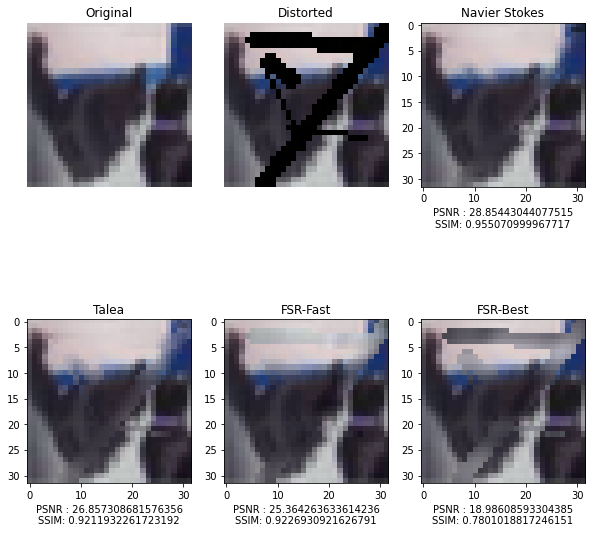

In [54]:
outputNS = cv2.inpaint(masked_image, mask_inp, 4, cv2.INPAINT_NS)
outputTelea = cv2.inpaint(masked_image, mask_inp, 4, cv2.INPAINT_TELEA)

outputFsrFast = masked_image.copy()
outputFsrBest = masked_image.copy()
cv2.xphoto.inpaint(masked_image, mask_inp_inv, outputFsrFast, cv2.xphoto.INPAINT_FSR_FAST)
cv2.xphoto.inpaint(masked_image, mask_inp_inv, outputFsrBest, cv2.xphoto.INPAINT_FSR_BEST)

dstFsrFast = cv2.cvtColor(outputFsrFast, cv2.COLOR_BGR2RGB)
dstFsrBest = cv2.cvtColor(outputFsrBest, cv2.COLOR_BGR2RGB)
dstNS = cv2.cvtColor(outputNS, cv2.COLOR_BGR2RGB)
dstTelea = cv2.cvtColor(outputTelea, cv2.COLOR_BGR2RGB)
dst = cv2.cvtColor(masked_image, cv2.COLOR_BGR2RGB)
img1 = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

psnrNS = cv2.PSNR(img, outputNS, 255)
ssimNS = SSIM(img, outputNS, multichannel=True)

psnrTelea = cv2.PSNR(img, outputTelea, 255)
ssimTelea = SSIM(img, outputTelea, multichannel=True)

psnrFsrFast = cv2.PSNR(img, outputFsrFast, 255)
ssimFsrFast = SSIM(img, outputFsrFast, multichannel=True)

psnrFsrBest = cv2.PSNR(img, outputFsrBest, 255)
ssimFsrBest = SSIM(img, outputFsrBest, multichannel=True)

plt.figure(figsize=(10, 10))

plt.subplot(2, 3, 1)
plt.imshow(img1)
plt.axis('Off')
plt.title('Original')

plt.subplot(2, 3, 2)
plt.imshow(dst)
plt.axis('Off')
plt.title('Distorted')

plt.subplot(2, 3, 3)
plt.imshow(dstNS)
plt.title('Navier Stokes')
plt.xlabel('PSNR : ' + str(psnrNS) + '\nSSIM: ' + str(ssimNS))

plt.subplot(2, 3, 4)
plt.imshow(dstTelea)
plt.title('Talea')
plt.xlabel('PSNR : ' + str(psnrTelea) + '\nSSIM: ' + str(ssimTelea))

plt.subplot(2, 3, 5)
plt.imshow(dstFsrFast)
plt.title('FSR-Fast')
plt.xlabel('PSNR : ' + str(psnrFsrFast) + '\nSSIM: ' + str(ssimFsrFast))

plt.subplot(2, 3, 6)
plt.imshow(dstFsrBest)
plt.title('FSR-Best')
plt.xlabel('PSNR : ' + str(psnrFsrBest) + '\nSSIM: ' + str(ssimFsrBest))